# Practice: A Visual Notebook to Using BERT for the First Time

*Credits: first part of this notebook is strongly based on Jay Alammar's [great blog post](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/). His blog is a great way to dive into the DL and NLP concepts.*

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-sentence-classification.png" />

In this notebook, we will use pre-trained deep learning model to process some text. We will then use the output of that model to classify the text. The text is a list of sentences from film reviews. And we will calssify each sentence as either speaking "positively" about its subject of "negatively".

## Models: Sentence Sentiment Classification

Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset

The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library

Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [1]:
!pip install -Uqq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 16.7 MB/s eta 0:00:00


## Part 1. Using BERT for text classification.

## Loading pretrained BERT.

Here we will be using the pretrained DistilBERT model from `transformers` library. The easiest way to use such model is to use a `pipeline`. This can be done as follows:

In [3]:
from transformers import pipeline


unmasker = pipeline('fill-mask', 'distilbert-base-uncased')
unmasker("Hello I'm a [MASK] model.")

[{'score': 0.05292844399809837,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i'm a role model."},
 {'score': 0.03968599811196327,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i'm a fashion model."},
 {'score': 0.034743644297122955,
  'token': 2449,
  'token_str': 'business',
  'sequence': "hello i'm a business model."},
 {'score': 0.03462294861674309,
  'token': 2944,
  'token_str': 'model',
  'sequence': "hello i'm a model model."},
 {'score': 0.01814521849155426,
  'token': 11643,
  'token_str': 'modeling',
  'sequence': "hello i'm a modeling model."}]

However, such approach is not very flexible and certainly doesn't allow you to fine-tune a model. For this reason we will use the model in a more manual way. For this we load the model and appropriate tokenizer and use them together. Here is how we can use them to extract features from our text:

In [4]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer, logging


logging.set_verbosity_error()  # Ignore warning on model loading.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit.'
tokenized_text = tokenizer(text, return_tensors='pt')

with torch.no_grad():
    output = model(**tokenized_text)

output.last_hidden_state.shape

torch.Size([1, 23, 768])

Except for the `logging` part, everything looks very similar to the code we saw in previous practice notebooks. The first thing we do is, just like always, tokenize our text.

> **Note:** as you can see, we used `return_tensors` keyword argument in code above. This parameters just tells tokenizer to convert result into a PyTorch tensors to use them with our model. If we don't specify this parameter, we will get exactly same results, but packed into a python `list` objects.

Let's look at this step a little closer. What exactly does the `tokenizer.__call__` return? Let's find out:

In [5]:
tokenized_text = tokenizer(text)

for key, values in tokenized_text.items():
    values_type = type(values).__name__
    item_type = type(values[0]).__name__
    values_sample = f"[{', '.join(str(value) for value in values[:5])}, ...]"
    print(f"{key}: {values_type}[{item_type}], length {len(values)}: {values_sample}")

input_ids: list[int], length 23: [101, 19544, 2213, 12997, 17421, ...]
attention_mask: list[int], length 23: [1, 1, 1, 1, 1, ...]


The contents may differ for different models, however for the `DistilBert` model tokenizer returns a `dict`-like object with two python lists under keys `"input_ids"` and `"attention_mask"`. Both lists have the same length and the attention mask seems to only have ones. We'll deal with the mask later, for now let's focus on `"input_ids"` which is the token ids for the tokenized sequence. Let's decode them to make sure and see what is actually going on:

In [6]:
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'])}")
print(f"Decoded sequence: '{tokenizer.decode(tokenized_text['input_ids'])}'")

Tokens: ['[CLS]', 'lore', '##m', 'ip', '##sum', 'do', '##lor', 'sit', 'am', '##et', ',', 'con', '##se', '##ct', '##et', '##ur', 'adi', '##pis', '##cing', 'eli', '##t', '.', '[SEP]']
Decoded sequence: '[CLS] lorem ipsum dolor sit amet, consectetur adipiscing elit. [SEP]'


We see that tokenizer actually does quite a lot of work behind the curtains: it lowercases the sequence (remember, we use `*-uncased` model, which implies that it doesn't understand the upper case), adds special tokens (`[CLS]` and `[SEP]`) and applies the BPE. That is how we get 23 tokens for such a little text.

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

## Loading the dataset

However, working with manually edited sentence is not interesting. Let's use our model to work with a dataset for sentiment classification. We'll use pandas to read the dataset and load it into a dataframe.

In [7]:
import pandas as pd


dataset_url = (
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv'
)
dataset = pd.read_csv(dataset_url, delimiter='\t', header=None)
dataset.columns = ['text', 'label']
dataset.head()

,text,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


For performance reasons, we'll only use 2,000 sentences from the dataset

In [8]:
dataset = dataset[:2000]

We can ask pandas how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)

In [9]:
dataset['label'].value_counts()

1    1041
0     959
Name: label, dtype: int64

## Preparing the Dataset

Before we can hand our sentences to BERT, we need to so some processing to put them in the format it requires. First, let's split our `dataset` into separate `texts` and `labels`.

In [10]:
texts = dataset['text'].tolist()
labels = dataset['label'].values

Now we need to tokenize our texts.

In [11]:
# YOUR CODE HERE
# Tokenize the texts in dataset.
# Hint: our tokenizer can also work with lists of strings.
# tokenized_texts = ...
tokenized_texts = tokenizer(texts)

for key, values in tokenized_texts.items():
    values_type = type(values).__name__
    item_type = type(values[0]).__name__
    print(f"{key}: {values_type}[{item_type}], length {len(values)}")

input_ids: list[list], length 2000
attention_mask: list[list], length 2000


We obtained a list of lists. However, what we want is `torch.tensor` so that we could use it with our model. It's time to remember how we used to specify the `return_tensors` option! However, if we were to just specify it blindly, we would get an error. The problem here lies in the fact that sequences tend to have different lenghts:

In [12]:
for seq in tokenized_texts["input_ids"][:5]:
    print(len(seq))

20
16
45
22
25


The most common solution to this problem, often used in NLP is the use of padding. Luckily for us, tokenizer from `transformers` can do the padding for us:

In [13]:
tokenized_texts = tokenizer(dataset['text'].tolist(), return_tensors="pt", padding=True)

for key, values in tokenized_texts.items():
    values_type = type(values).__name__
    print(f"{key}: {values_type}, {values.shape}")

input_ids: Tensor, torch.Size([2000, 59])
attention_mask: Tensor, torch.Size([2000, 59])


However, we just added lot's of extra items into most of our sequences:

In [14]:
tokenized_texts["input_ids"]

tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
        [  101,  4593,  2128,  ...,     0,     0,     0],
        [  101,  2027,  3653,  ...,     0,     0,     0],
        ...,
        [  101,  2023,  2028,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  1996,  3185,  ...,     0,     0,     0]])

Note how all the sequences end with zeros. We already encountered such a problem, when trained our RNN on previous lessons and we tackled it with specifying the padding index to the `CrossEntropyLoss` so that our model doesn't train to predict padding. Right now we don't want to train our model to do anything, however, we are working with a transformer, which means that it uses the self-attention operation extensively. If we were to simply add these extra items, it would be likely to affect our results. And this is exactly the place where the `"attention_mask"` comes into play. It is used exactly to mask the padding from getting in a way of attention!

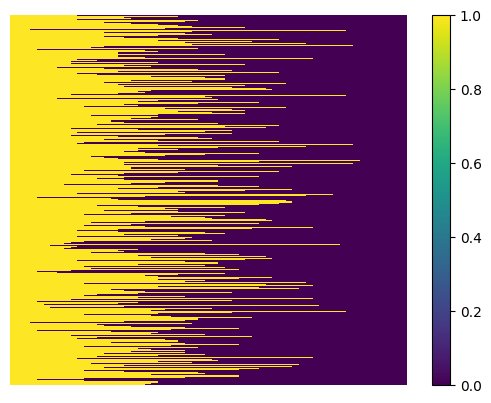

In [15]:
import matplotlib.pyplot as plt


plt.pcolormesh(tokenized_texts["attention_mask"])
plt.axis("off")
plt.colorbar()
plt.show()

## And Now, Deep Learning!

Now that we have our model and inputs ready, let's run our model! However, running it on a cpu takes several minutes. We can speed this up via using the GPU. For this, however, we would need to split our dataset into batches of data.

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model. Also remember, how we created the `labels` variable to hold our labels.

In [16]:
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 32
features = []
with torch.no_grad():
    for i in range(0, len(texts), batch_size):
        texts_batch = tokenized_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = tokenized_texts["attention_mask"][i : i + batch_size].to(device)
        output = model(texts_batch, masks_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)

features = np.concatenate(features, axis=0)
features.shape

(2000, 768)

## Classifier training

Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

In [17]:
from sklearn.model_selection import train_test_split


train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

We can dive into Logistic regression directly with the Scikit Learn default parameters, but sometimes it's worth searching for the best value of the C parameter, which determines regularization strength.

In [ ]:
# YOUR CODE HERE
# [EXTRA] Grid search for parameters

We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the best hyperparameter values into the model declaration.

In [18]:
import warnings

from sklearn.linear_model import LogisticRegression


warnings.simplefilter('ignore')  # Ignore warning on model fitting.
lr_clf = LogisticRegression().fit(train_features, train_labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-training-logistic-regression.png" />

So how well does our model do in classifying sentences? One way is to check the accuracy against the testing dataset:

In [19]:
lr_clf.score(test_features, test_labels)

0.822

Another way to evaluate classification model is to plot the ROC curve and compute the area under it.

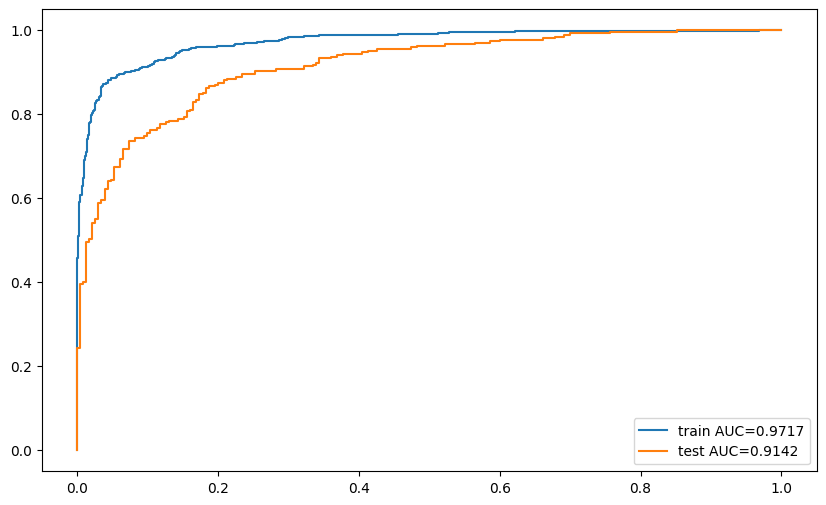

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve


plt.figure(figsize=(10, 6))

proba = lr_clf.predict_proba(train_features)[:, 1]
auc = roc_auc_score(train_labels, proba)
plt.plot(*roc_curve(train_labels, proba)[:2], label=f'train AUC={auc:.4f}')

proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, proba)
plt.plot(*roc_curve(test_labels, proba)[:2], label=f'test AUC={auc:.4f}')

plt.legend()
plt.show()

How good is this score? What can we compare it against? Let's first look at a dummy classifier:

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


clf = DummyClassifier()
scores = cross_val_score(clf, train_features, train_labels)
print(f"Dummy classifier score: {scores.mean():.3f} (+/- {2 * scores.std():.3f})")

Dummy classifier score: 0.514 (+/- 0.003)


So our model clearly does better than a dummy classifier. But how does it compare against the best models?

For reference, the [highest accuracy score](http://nlpprogress.com/english/sentiment_analysis.html) for this dataset is currently **96.8**. DistilBERT can be trained to improve its score on this task – a process called **fine-tuning** which updates BERT’s weights to make it achieve a better performance in this sentence classification task (which we can call the downstream task). The fine-tuned DistilBERT turns out to achieve an accuracy score of **90.7**. The full size BERT model achieves **94.9**.

And that’s it! That’s a good first contact with BERT. The next step would be to head over to the documentation and try your hand at [fine-tuning](https://huggingface.co/transformers/examples.html#glue). You can also go back and switch from distilBERT to BERT and see how that works.

## Part 2: Looking back.

Now it is your turn to reproduce the steps above.

We shall revisit the first homework and see whether we could improve the results a little bit more. The average ROC-AUC on test set was around $0.9$ (using the words embeddings).

__Let's see whether we can beat it.__

In [22]:
dataset_url = 'https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv'
dataset = pd.read_csv(dataset_url, sep='\t')
dataset.head()

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


One last note: this dataset contains some very long sentences, while the vast majority of sequences fall into category of 500 tokens and less:

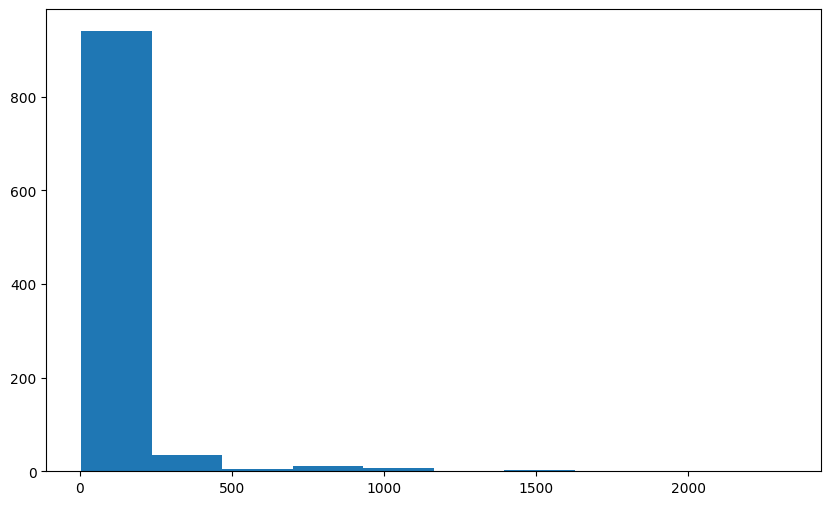

In [23]:
texts = dataset["comment_text"].tolist()
tokenized_texts = tokenizer(texts)
ids_lens = list(len(toks) for toks in tokenized_texts["input_ids"])

plt.figure(figsize=(10, 6))
plt.hist(ids_lens)
plt.show()

We already know, how to tackle the problem of different sizes of sequences with padding. However, blind padding here would make pad all the sequenes to the size of the largest one, which seems to be an overkill. In such case it might be sensible to actually truncate the too-long sequences into a fixed length, say 512. And we can do this easily by specifying the `max_length` and `truncation=True` arguments to the tokenizer.

In [24]:
# YOUR CODE HERE
tokenized_texts = tokenizer(
    texts, max_length=3, return_tensors="pt", padding=True, truncation=True
)

features = []
with torch.no_grad():
    for i in range(0, len(texts), batch_size):
        texts_batch = tokenized_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = tokenized_texts["attention_mask"][i : i + batch_size].to(device)
        output = model(texts_batch, masks_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)

features = np.concatenate(features, axis=0)
features.shape

(1000, 768)

In [25]:
labels = dataset["should_ban"].values
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression(C=0.1)
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.716

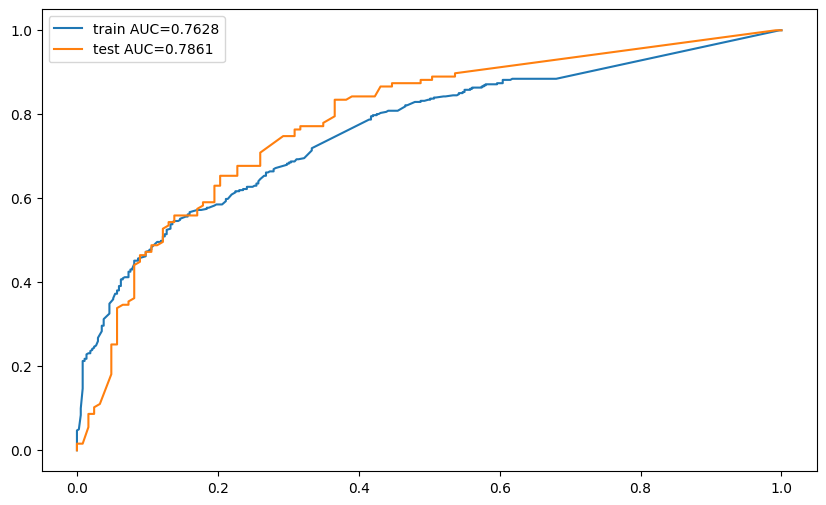

In [26]:
plt.figure(figsize=(10, 6))

proba = lr_clf.predict_proba(train_features)[:, 1]
auc = roc_auc_score(train_labels, proba)
plt.plot(*roc_curve(train_labels, proba)[:2], label=f'train AUC={auc:.4f}')

proba = lr_clf.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, proba)
plt.plot(*roc_curve(test_labels, proba)[:2], label=f'test AUC={auc:.4f}')

plt.legend()
plt.show()

So, how does it look? Did we achieve better results?

Here come some further ideas:

* Try using the larger BERT (e.g. BERT-base or BERT-large) and compare the results (be careful, they require more memory).

* Using BERT output for translation? Why not ;)